plot treatment effects

In [4]:
# set plot & display style; packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.style.use('ggplot')

C:\Users\jiawei\AppData\Local\Temp\ipykernel_21600\2878009125.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [ ]:
# load regression results
RegressionResults = pd.read_csv('regression_results.csv')
regression_type = RegressionResults['regression_type'].unique()
# ['zoreflat', 'lm', '100plm', 'negbio']
outcome_type = RegressionResults['outcome_type'].unique()
# ['citation', 'RCACC', 'RCSP', 'CCACC', 'CCSP']
print(RegressionResults['discipline'].unique())
# delete some small sample disciplines
RegressionResults = RegressionResults.loc[~RegressionResults['discipline'].isin(
    ['Art', 'History', 'Political Science', 'Philosophy', 'Business', 'Environmental Science', 'Sociology', 'Medicine'])]
# disciplines = RegressionResults['discipline'].unique()
# disciplines
custom_dict = {'Medicine': 0, 'Physics': 1, 'Mathematics': 2,'Chemistry': 3,'Computer Science': 4,
               'Engineering': 5, 'Materials Science': 6, 'Biology': 7, 'Economics': 8, 'Geology': 9, 'Psychology': 10}

RegressionResults = RegressionResults.sort_values(by=['discipline'], key=lambda x: x.map(custom_dict))


['Art' 'History' 'Chemistry' 'Philosophy' 'Computer Science' 'Engineering'
 'Materials Science' 'Biology' 'Environmental Science' 'Political Science'
 'Economics' 'Sociology' 'Geology' 'Business' 'Psychology' 'Medicine'
 'Physics' 'Mathematics']


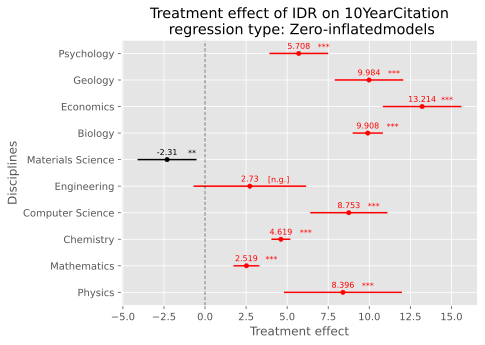

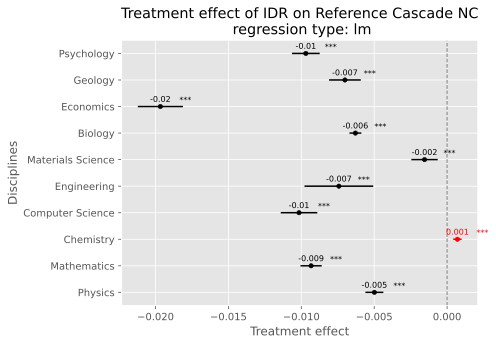

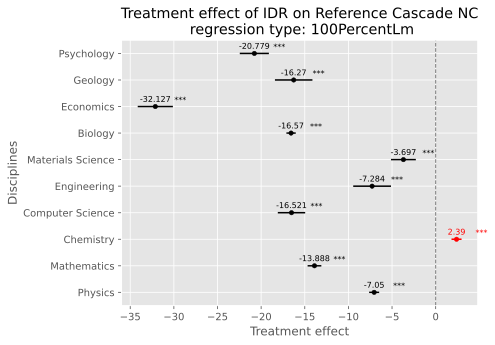

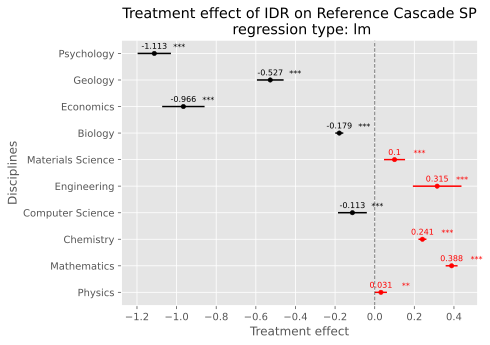

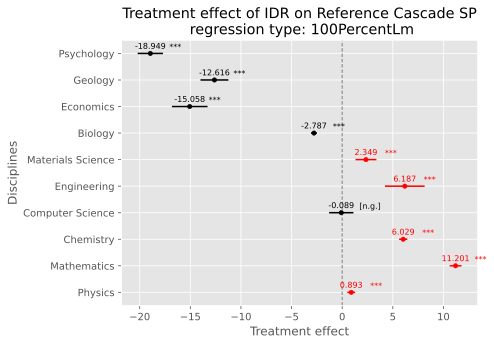

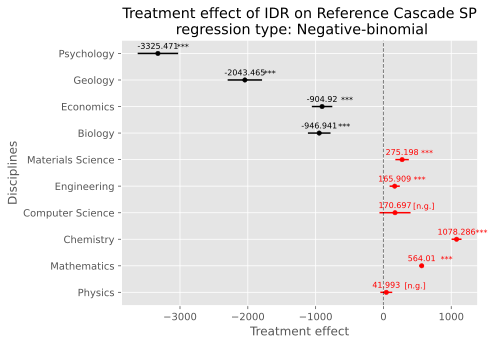

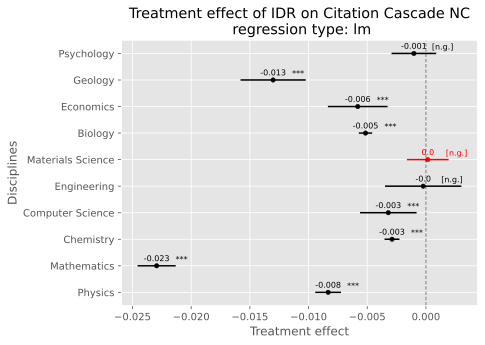

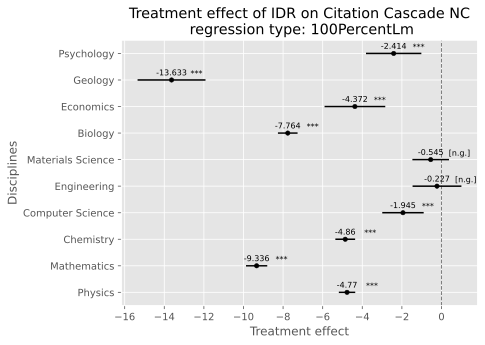

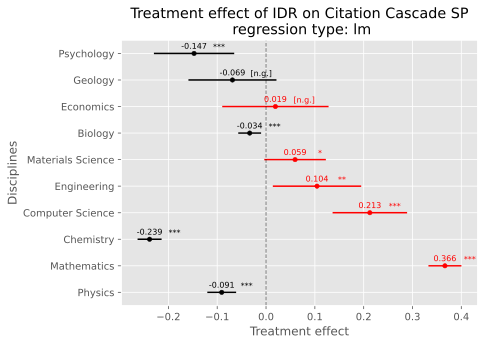

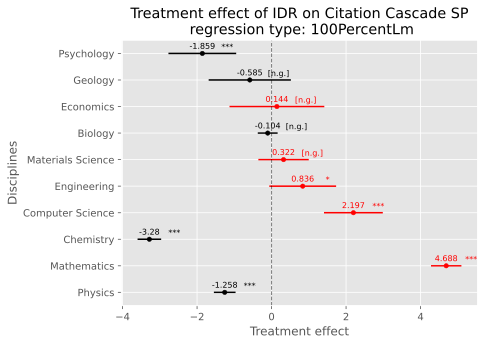

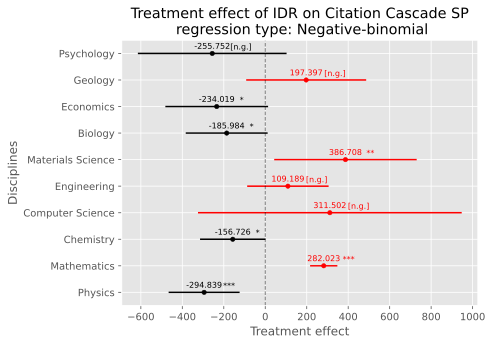

In [6]:
# draw
for outcome in outcome_type:
    for regression in regression_type:
        # start loop
        tempdf = RegressionResults.loc[(RegressionResults['outcome_type'] == outcome) & (
            RegressionResults['regression_type'] == regression)]
        # for empty combination, continue
        if len(tempdf) == 0:
            continue

        # extract lists
        disciplines = tempdf['discipline']
        estimate = tempdf['estimate']
        lower_bound = tempdf['conf.low']
        upper_bound = tempdf['conf.high']
        p = tempdf['p.value']

        # confidence interval
        xerr = [
            [value-lower for value, lower in zip(estimate, lower_bound)],
            [upper-value for value, upper in zip(estimate, upper_bound)],
        ]
        # set negative effects to black; set positive effects to red
        positive_or_negative = np.any(np.array([estimate]) < 0, axis=0)
        colors = np.where(positive_or_negative, 'black', 'red')

        # draw
        fig, ax = plt.subplots()
        ax.axvline(x=0, c='black', ls='--', lw=1, alpha=0.5)

        # height-width ratio
        # ax.set_aspect(3)
        ax.set_xlabel('Treatment effect')
        ax.set_title('Treatment effect of IDR on' + " " +
                     outcome + "\n regression type: "+regression)
        ax.set_ylabel('Disciplines')
        ax.scatter(estimate, disciplines, c=colors, s=80, marker='.')
        ax.set_ylim(-0.5, len(disciplines) - 0.5)  # add some vertical padding
        # ax.set_xlim(-6,15)
        ax.errorbar(estimate, disciplines, xerr=xerr,
                    fmt='none',     # don't connect data points
                    ecolor=colors,  # color of error lines
                    elinewidth=1.5,   # width of error lines
                    capsize=0,      # length of error caps
                    zorder=1,      # put error bars behind scatter points
                    )

        for value, lower, upper, label, color, pv in zip(estimate, lower_bound, upper_bound, disciplines, colors, p):
            shared = dict(xy=(value, label), color=color,
                          textcoords='offset points', ha='center', fontsize=8)
            ax.annotate(round(value, 3), xytext=(0, 3), va='bottom', **shared)
            # ax.annotate(f'[{round(lower,2)}, {round(upper,2)}]', xytext=(0, -3), va='top', **shared)
            if pv < 0.01:
                ax.annotate(f'***',
                    xytext=(25, 10), va='top', **shared)
            elif pv < 0.05:
                ax.annotate(f'**',
                    xytext=(25, 10), va='top', **shared)
            elif pv < 0.10001:
                ax.annotate(f'*',
                    xytext=(25, 10), va='top', **shared)
            else:
                ax.annotate(f'   [n.g.]',
                    xytext=(25, 10), va='top', **shared)

        f = plt.gcf()
        f.savefig('new_%s+%s.png' % (outcome, regression),
                  bbox_inches='tight', dpi=400)
